In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

# Input Data

In [2]:
df1= pd.read_csv('Monthly_data_cmo.csv')
df2=pd.read_csv('CMO_MSP_Mandi.csv')

# Cleaning Data

In [3]:
df1['date'] =  pd.to_datetime(df1['date'])
df1['Commodity']=df1['Commodity'].str.lower()
df1['Commodity'] = df1['Commodity'].str.replace('bhagar/vari','bhagar-vari')
df1['Commodity'] = df1['Commodity'].str.replace('thymol/lovage','thymol-lovage')
df2['commodity']=df2['commodity'].str.lower()

In [4]:
df1=df1[(df1['min_price']<=df1['max_price']) & (df1['modal_price'] <= df1['max_price'])]
df1=df1[(df1['max_price']>0) & (df1['modal_price']>0) & (df1['max_price']<=1000000)]

# Seprating Data based on commodity and APMC

In [5]:
commodity=df1.Commodity.unique()
apmc=df1.APMC.unique()

In [7]:
n=commodity.size
m=apmc.size
test={}
A=pd.DataFrame(columns=['Key','Commodity','APMC'])
q=0
for i in range(0,n):
  for j in range(0,m):
    if df1[(df1['APMC'] == apmc[j]) & (df1['Commodity'] == commodity[i])].empty:
        continue
    else:
        test[q]=df1[(df1['APMC'] == apmc[j]) & (df1['Commodity'] == commodity[i])]
        test[q]= pd.merge(test[q], df2, how='left',left_on=['Commodity','Year'], right_on=['commodity','year']).set_index('date')
        A.loc[q]=([q, commodity[i], apmc[j]])
        q+=1
       

# Processing to find seasonality in prices

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
for key in test.keys():
    if test[key]['modal_price'].size >2:
        result = seasonal_decompose(test[key]['modal_price'], model='multiplicative', freq=2)
        if np.mean(result.seasonal) == 0:
            test[key]['seasonality']='multiplicative'
            test[key]['deseasonal']=result.trend
            test[key]['Peak seasonal price fluctuation %']=max(((test[key]['modal_price'].max()-test[key]['modal_price'].mean())*100)/test[key]['modal_price'].mean(),((test[key]['modal_price'].mean()-test[key]['modal_price'].min())*100)/test[key]['modal_price'].mean())
        else:
            result = seasonal_decompose(test[key]['modal_price'], model='additive', freq=2)
            if np.mean(result.seasonal) == 0:
                test[key]['seasonality']='additive'
                test[key]['deseasonal']=result.trend
                test[key]['Peak seasonal price fluctuation %']=max(((test[key]['modal_price'].max()-test[key]['modal_price'].mean())*100)/test[key]['modal_price'].mean(),((test[key]['modal_price'].mean()-test[key]['modal_price'].min())*100)/test[key]['modal_price'].mean())
            else:
                test[key]['seasonality']='not found'
                test[key]['deseasonal']=np.nan
    else:
        test[key]['seasonality']='not found'
        test[key]['deseasonal']=np.nan
    if (np.mean(test[key]['msp_filter']==1)):
        test[key]['Raw vs MSP diff']=test[key]['modal_price']-test[key]['msprice']
        test[key]['Desasonal vs MSP diff']=test[key]['deseasonal']-test[key]['msprice']


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Saving processed records to files

In [12]:
for key in test.keys():
            test[key].to_csv(r'Output/output_{}-{}.csv'.format(A.loc[key]['Commodity'],A.loc[key]['APMC']),index=True,header=True)
A.to_csv(r'Output/Output_key.csv',index=True,header=True)

KeyboardInterrupt: 

# Configurng user interface




Check out the data


                APMC Commodity  Year      Month  arrivals_in_qtl  min_price  \
date                                                                          
2015-04-01  Baramati   jaggery  2015      April              666       1994   
2016-04-01  Baramati   jaggery  2016      April             2623       2912   
2015-08-01  Baramati   jaggery  2015     August              587       2068   
2016-08-01  Baramati   jaggery  2016     August             3009       3792   
2014-12-01  Baramati   jaggery  2014   December              396       2200   
2015-12-01  Baramati   jaggery  2015   December             1545       2300   
2015-02-01  Baramati   jaggery  2015   February               58       1800   
2016-02-01  Baramati   jaggery  2016   February             4306       2451   
2015-01-01  Baramati   jaggery  2015    January              558       2178   
2016-01-01  Baramati   jaggery  2016    January             3284       2453   
2015-07-01  Baramati   jagge

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


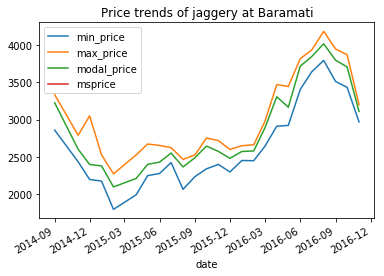

In [29]:
print('-'*50)
print('Welcome to Maharashtra dashboard')
print('='*50)
print("\n")
print("Please select the trends you want to see and enter its key")
print("\n")
print(A)
print("\n")
sel=int(input("  Enter the key \n"))
print("\n\n")
from IPython.display import clear_output
clear_output()
test[sel].plot(y=['min_price', 'max_price','modal_price','msprice'],title='Price trends of {} at {}'.format(A.loc[sel]['Commodity'],A.loc[sel]['APMC']))
print("\n\n")
print("Check out the data")
print("\n")
print(test[sel])